In [ ]:
# Install necessary package
!pip install transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import time
import numpy as np
import matplotlib.pyplot as plt
import os

dataset_path = "/content/drive/MyDrive/imp_finetuneed/legal_datasets.csv"
df = pd.read_csv(dataset_path, on_bad_lines='skip')
print(df.shape)
df.sample(20)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/imp_finetuneed/legal_datasets.csv'

In [ ]:
df = df.dropna(subset=['Query', 'Label'])  # Ensure no NaN values in 'Query' column
queries = df.Query.values
labels = df.Label.values

In [ ]:
# Process labels
queries = df.Query.values
labels = df.Label.values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Load Bert Tokenizer
print("Loading Bert Tokenizer")
tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased', do_lower_case=True)

# Tokenization and Input IDs
input_ids = [tokenizer.encode(query, add_special_tokens=True) for query in queries]


Loading Bert Tokenizer


In [ ]:
print(len(label_encoder.classes_))

81


In [ ]:
# Split 10% for Testing
train_val_inputs, test_inputs, train_val_labels, test_labels = train_test_split(
    input_ids, labels, test_size=0.1, random_state=2024
)


# Step 2: Split Remaining 90% into 70% Training & 20% Validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    train_val_inputs, train_val_labels, test_size=2/9, random_state=2024
)


In [ ]:
# Pad sequences
MAX_LEN = 128
def pad_sequences(inputs):
    return np.array([np.pad(seq, (0, MAX_LEN - len(seq)), 'constant') if len(seq) < MAX_LEN else seq[:MAX_LEN] for seq in inputs])

train_inputs = pad_sequences(train_inputs)
validation_inputs = pad_sequences(validation_inputs)
test_inputs = pad_sequences(test_inputs)


In [ ]:
# Create attention masks
def create_attention_mask(input_sequences):
    return np.where(input_sequences != 0, 1, 0)

train_masks = create_attention_mask(train_inputs)
validation_masks = create_attention_mask(validation_inputs)
test_masks = create_attention_mask(test_inputs)


In [ ]:
# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

# Print shapes
print(f"Training inputs shape: {train_inputs.shape}")
print(f"Validation inputs shape: {validation_inputs.shape}")
print(f"Test inputs shape: {test_inputs.shape}")
print(f"Training masks shape: {train_masks.shape}")
print(f"Validation masks shape: {validation_masks.shape}")
print(f"Test masks shape: {test_masks.shape}")


Training inputs shape: torch.Size([13006, 128])
Validation inputs shape: torch.Size([3716, 128])
Test inputs shape: torch.Size([1859, 128])
Training masks shape: torch.Size([13006, 128])
Validation masks shape: torch.Size([3716, 128])
Test masks shape: torch.Size([1859, 128])


In [ ]:
# Prepare DataLoader
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Define the model path
model_path = "/content/drive/MyDrive/imp_finetuneed/model"  # Change this to your actual path

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import torch.nn.functional as F
# import numpy as np

# def evaluate(model, dataloader, device, label_encoder, criterion):
#     model.eval()
#     total_loss = 0
#     all_preds =[]
#     all_labels = []

#     print("Starting evaluation...")  # Debugging log

#     with torch.no_grad():
#         for batch_idx, batch in enumerate(dataloader):
#             print(f"Processing batch {batch_idx+1}/{len(dataloader)}...", end="\r")  # Show batch progress

#             # Move batch data to the correct device
#             input_ids = batch[0].to(device)
#             attention_mask = batch[1].to(device)
#             labels = batch[2].to(device)

#             # Forward pass
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             logits = outputs.logits

#             # Compute loss
#             loss = criterion(logits, labels)
#             total_loss += loss.item()

#             # Get predictions
#             preds = torch.argmax(logits, dim=1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     avg_loss = total_loss / len(dataloader)
#     accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
#     labels = list(range(79))  # Assuming you have 79 unique classes in y_true

#     class_report = classification_report(true_labels, predictions, labels=labels, target_names=label_encoder.classes_)
#     conf_matrix = confusion_matrix(all_labels, all_preds)

#     print("Evaluation completed!")  # Debugging log

#     return avg_loss, accuracy, class_report, conf_matrix, all_preds, all_labels



In [ ]:
print(f"Number of labels in fine-tuned model: {model.config.num_labels}")


Number of labels in fine-tuned model: 81


In [ ]:
print(f"Total labels in dataset: {len(set(true_labels))} → {set(true_labels)}")
print(f"Total predicted labels: {len(set(predictions))} → {set(predictions)}")
print(f"Total classes in label encoder: {len(label_encoder.classes_)} → {set(range(len(label_encoder.classes_)))}")


Total labels in dataset: 79 → {0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80}
Total predicted labels: 78 → {3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80}
Total classes in label encoder: 81 → {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74

In [ ]:
import torch.nn as nn

# Define loss function
criterion = nn.CrossEntropyLoss()


# Call the evaluate function
avg_val_loss, val_accuracy, class_report, conf_matrix, predictions, true_labels = evaluate(
    model, test_dataloader, device, label_encoder, criterion
)

# Convert to sets
predicted_classes = set(predictions)
true_classes = set(true_labels)
label_encoder_classes = set(range(len(label_encoder.classes_)))

# Print debug information
print(f"Unique predicted classes: {len(predicted_classes)} → {predicted_classes}")
print(f"Unique true labels: {len(true_classes)} → {true_classes}")
print(f"Classes in label encoder: {len(label_encoder_classes)} → {label_encoder_classes}")

# Find missing or extra classes
missing_classes = label_encoder_classes - predicted_classes
extra_classes = predicted_classes - label_encoder_classes

print(f"Classes present in label encoder but not predicted: {missing_classes}")
print(f"Classes predicted but not in label encoder: {extra_classes}")

# Print classification report and confusion matrix
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Starting evaluation...
Evaluation completed!


ValueError: not enough values to unpack (expected 6, got 5)

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import torch.nn.functional as F
# import numpy as np
# import torch.nn as nn
# import seaborn as sns
# import matplotlib.pyplot as plt

# def evaluate(model, dataloader, device, label_encoder, criterion):
#     model.eval()
#     total_loss = 0
#     all_preds = []
#     all_labels = []

#     print("Starting evaluation...")  # Debugging log

#     with torch.no_grad():
#         for batch_idx, batch in enumerate(dataloader):
#             print(f"Processing batch {batch_idx+1}/{len(dataloader)}...", end="\r")  # Show batch progress

#             # Move batch data to the correct device
#             input_ids = batch[0].to(device)
#             attention_mask = batch[1].to(device)
#             labels = batch[2].to(device)

#             # Forward pass
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             logits = outputs.logits

#             # Compute loss
#             loss = criterion(logits, labels)
#             total_loss += loss.item()

#             # Get predictions
#             preds = torch.argmax(logits, dim=1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     avg_loss = total_loss / len(dataloader)
#     accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

#     # Use the actual number of unique classes, assuming 79 unique classes
#     labels = list(range(79))  # Assuming you have 79 unique classes in y_true

#     # Use all_labels and all_preds here instead of true_labels and predictions
#     class_report = classification_report(all_labels, all_preds, labels=labels, target_names=label_encoder.classes_)
#     conf_matrix = confusion_matrix(all_labels, all_preds)

#     print("Evaluation completed!")  # Debugging log

#     return avg_loss, accuracy, class_report, conf_matrix, all_preds, all_labels


# # Define loss function
# criterion = nn.CrossEntropyLoss()

# # Call the evaluate function
# avg_val_loss, val_accuracy, class_report, conf_matrix, predictions, true_labels = evaluate(
#     model, test_dataloader, device, label_encoder, criterion
# )

# # Convert to sets
# predicted_classes = set(predictions)
# true_classes = set(true_labels)
# label_encoder_classes = set(range(len(label_encoder.classes_)))

# # Print debug information
# print(f"Unique predicted classes: {len(predicted_classes)} → {predicted_classes}")
# print(f"Unique true labels: {len(true_classes)} → {true_classes}")
# print(f"Classes in label encoder: {len(label_encoder_classes)} → {label_encoder_classes}")

# # Find missing or extra classes
# missing_classes = label_encoder_classes - predicted_classes
# extra_classes = predicted_classes - label_encoder_classes

# print(f"Classes present in label encoder but not predicted: {missing_classes}")
# print(f"Classes predicted but not in label encoder: {extra_classes}")

# # Print classification report and confusion matrix
# print("Classification Report:\n", class_report)
# print("Confusion Matrix:\n", conf_matrix)

# # Plot confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()


In [ ]:
# Assuming label_encoder.classes_ is the list of class labels
label_to_find = 'which is a common trick to steal money'  # Replace with the label you want to find the index of

# Get the index of the label
label_index = np.where(label_encoder.classes_ == label_to_find)[0][0]

print(f"The index of the label '{label_to_find}' is: {label_index}")


IndexError: index 0 is out of bounds for axis 0 with size 0

Starting evaluation...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 79, does not match size of target_names, 81
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_d

Evaluation completed!
Unique predicted classes: 78 → {3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80}
Unique true labels: 79 → {0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80}
Classes in label encoder: 81 → {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7

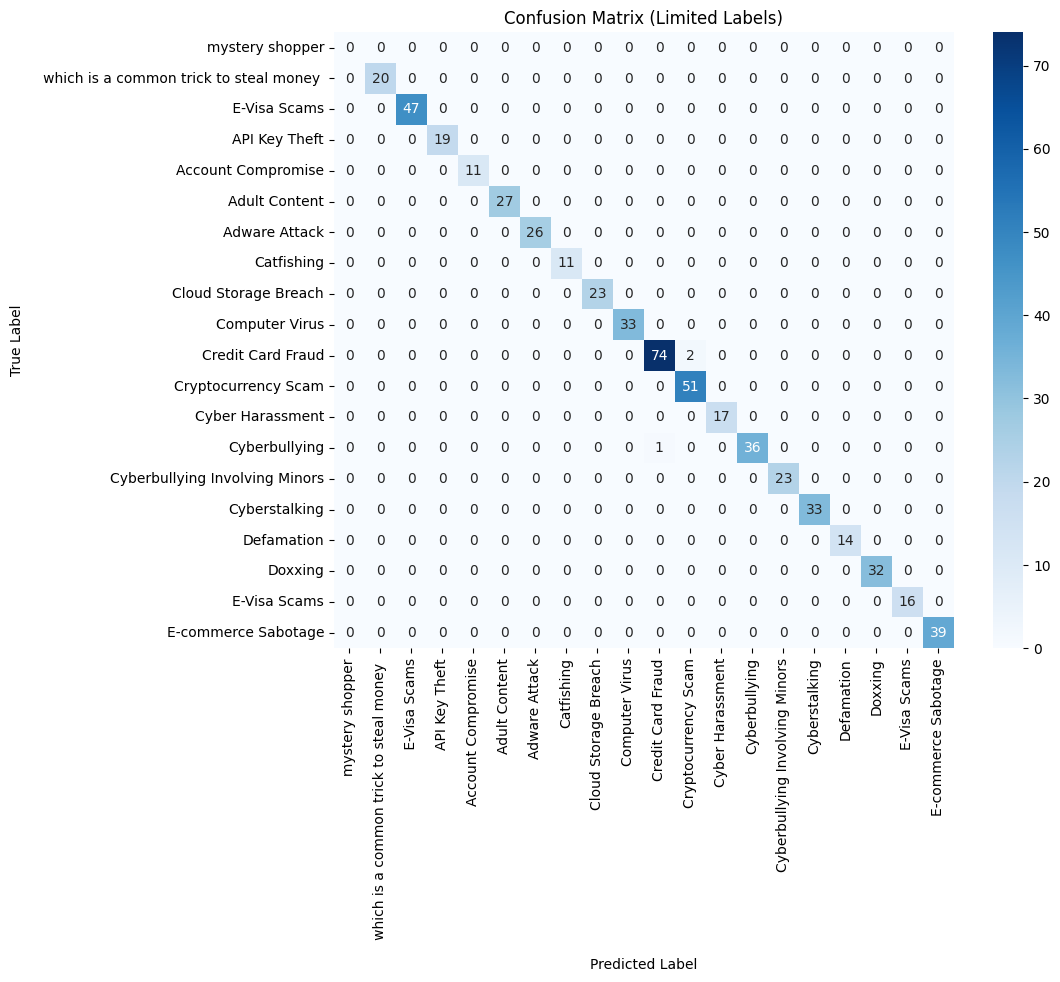

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, dataloader, device, label_encoder, criterion, max_labels=20):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    print("Starting evaluation...")  # Debugging log

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            print(f"Processing batch {batch_idx+1}/{len(dataloader)}...", end="\r")  # Show batch progress

            # Move batch data to the correct device
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    # Use the actual number of unique classes, assuming 79 unique classes
    labels = list(range(79))  # Assuming you have 79 unique classes in y_true

    # Use all_labels and all_preds here instead of true_labels and predictions
    class_report = classification_report(all_labels, all_preds, labels=labels, target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("Evaluation completed!")  # Debugging log

    return avg_loss, accuracy, class_report, conf_matrix, all_preds, all_labels


# Define loss function
criterion = nn.CrossEntropyLoss()

# Call the evaluate function
avg_val_loss, val_accuracy, class_report, conf_matrix, predictions, true_labels = evaluate(
    model, test_dataloader, device, label_encoder, criterion, max_labels=20
)

# Convert to sets
predicted_classes = set(predictions)
true_classes = set(true_labels)
label_encoder_classes = set(range(len(label_encoder.classes_)))

# Print debug information
print(f"Unique predicted classes: {len(predicted_classes)} → {predicted_classes}")
print(f"Unique true labels: {len(true_classes)} → {true_classes}")
print(f"Classes in label encoder: {len(label_encoder_classes)} → {label_encoder_classes}")

# Find missing or extra classes
missing_classes = label_encoder_classes - predicted_classes
extra_classes = predicted_classes - label_encoder_classes

print(f"Classes present in label encoder but not predicted: {missing_classes}")
print(f"Classes predicted but not in label encoder: {extra_classes}")

# Print classification report and confusion matrix
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

# Limit the number of labels on the confusion matrix
limited_labels = label_encoder.classes_[:20]  # Limit to first 20 labels

# Plot confusion matrix with limited labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix[:20, :20], annot=True, fmt='g', cmap='Blues', xticklabels=limited_labels, yticklabels=limited_labels)
plt.title('Confusion Matrix (Limited Labels)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, dataloader, device, label_encoder, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    print("Starting evaluation...")  # Debugging log

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            print(f"Processing batch {batch_idx+1}/{len(dataloader)}...", end="\r")  # Show progress

            # Move batch to device
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    # Create confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=np.arange(len(label_encoder.classes_)))

    print("Evaluation completed!")  # Debugging log
    return avg_loss, accuracy, conf_matrix, all_preds, all_labels


# Define loss function
criterion = nn.CrossEntropyLoss()

# Call the evaluate function
avg_val_loss, val_accuracy, conf_matrix, predictions, true_labels = evaluate(
    model, test_dataloader, device, label_encoder, criterion
)

# Convert label encoder classes to a list
label_classes = list(label_encoder.classes_)

# Remove specific label from label_encoder classes and adjust indices
label_to_remove = "   which is a common trick to steal money "

if label_to_remove in label_encoder.classes_:
    remove_idx = label_encoder.classes_.tolist().index(label_to_remove)  # Get index
    print(f"Removing label at index {remove_idx}: {label_to_remove}")

    # Remove the label from label list
    filtered_labels = [label for i, label in enumerate(label_encoder.classes_) if i != remove_idx]

    # Remove rows & columns of the corresponding label index
    conf_matrix = np.delete(conf_matrix, remove_idx, axis=0)  # Remove row
    conf_matrix = np.delete(conf_matrix, remove_idx, axis=1)  # Remove column
else:
    filtered_labels = label_encoder.classes_  # If label isn't found, use all labels

# Limit labels to first 20 (excluding removed label)
filtered_labels = filtered_labels[:20]
conf_matrix = conf_matrix[:20, :20]

# Debugging: Print the final label list to confirm removal
print("Filtered labels:", filtered_labels)

# Plot confusion matrix without the removed label
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix,
            annot=True, fmt='g', cmap='Blues',
            xticklabels=filtered_labels,
            yticklabels=filtered_labels)
plt.title('Confusion Matrix ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
